In [1]:
import numpy as np
import pandas as pd
import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
#Define testfile
test_file = 'Dataset/INDEX/ICEX Main (OMXIPI).xlsx'

# Create dataframe

df = pd.read_excel(test_file)
df_test = df.copy()

df.head()

,Date,Price,Open,High,Low,Volume,Change%
0,"Jun 19, 2017",1373.10,1372.44,1373.10,1372.26,6.20M,0.0006
1,"Jun 16, 2017",1372.27,1371.70,1374.33,1371.10,58.80M,0.0004
2,"Jun 15, 2017",1371.70,1378.95,1384.14,1369.99,159.24M,-0.0053
3,"Jun 14, 2017",1378.95,1380.79,1388.13,1378.37,87.17M,-0.0013
4,"Jun 13, 2017",1380.79,1376.24,1386.28,1375.89,169.50M,0.0033


# Pre processing

In [3]:
"""
# Below code is not in use at the moment
# Convert '6.20M' to int millions
def to_millions(data):
    if data[-1]== 'M':
        data=float(data[:-1])
        return int(data * 1000000)
    else:
        return int(data * 1000000)
    
# Remove rows with missing values for Volume 
# Might not need, volume might not be a good indicator as it reduces the number of datapoints from 1800 > 600 ish
df =df[df_test.Volume != '-']
# Convert volume from '6.20M' to '6,200,000'
df.Volume = df.Volume.apply(lambda x: to_millions(x))
"""

"\n# Below code is not in use at the moment\n# Convert '6.20M' to int millions\ndef to_millions(data):\n    if data[-1]== 'M':\n        data=float(data[:-1])\n        return int(data * 1000000)\n    else:\n        return int(data * 1000000)\n    \n# Remove rows with missing values for Volume \n# Might not need, volume might not be a good indicator as it reduces the number of datapoints from 1800 > 600 ish\ndf =df[df_test.Volume != '-']\n# Convert volume from '6.20M' to '6,200,000'\ndf.Volume = df.Volume.apply(lambda x: to_millions(x))\n"

In [4]:
# Convert timestamp to datetime
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.date())
df = df.sort('Date', ascending=True)

# Create returns
df['Return'] = df['Price'].pct_change(periods=1)
df['Return_shift'] = df.Return.shift(1)
df['Price_shift'] = df.Price.shift(1)
df['Return3'] = df['Price_shift'].pct_change(periods=3)
df['Return5'] = df['Price_shift'].pct_change(periods=5)
df['Return10'] = df['Price_shift'].pct_change(periods=10)
df['Return20'] = df['Price_shift'].pct_change(periods=20)
df['Return50'] = df['Price_shift'].pct_change(periods=50)

# Create moving price averages
df['3DaySMA'] = df['Price_shift'].rolling(center=False,window =3).mean()
df['5DaySMA'] = df['Price_shift'].rolling(center=False,window =5).mean()
df['10DaySMA'] = df['Price_shift'].rolling(center=False,window=10).mean()
df['20DaySMA'] = df['Price_shift'].rolling(center=False,window=20).mean()
df['50DaySMA'] = df['Price_shift'].rolling(center=False,window=50).mean()

# Exponential Weighted Moving Average
df['EWMA'] = pd.ewma(df.Price_shift, com=0.5)

# Drop NAN
# TODO: Find better approach
df = df.dropna()

# Show
df.head()

C:\Users\petur\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
C:\Users\petur\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,ignore_na=False,adjust=True,com=0.5).mean()


,Date,Price,Open,High,Low,Volume,Change%,Return,Return_shift,Price_shift,...,Return5,Return10,Return20,Return50,3DaySMA,5DaySMA,10DaySMA,20DaySMA,50DaySMA,EWMA
1806,2010-03-16,549.73,552.10,552.10,547.85,-,-0.0045,-0.004509,0.010504,552.22,...,0.018048,0.030031,0.091797,0.117764,549.323333,546.134,539.411,527.3435,512.6452,550.369914
1805,2010-03-17,556.05,549.74,556.62,549.74,-,0.0115,0.011497,-0.004509,549.73,...,0.022316,0.032783,0.087519,0.111756,549.476667,548.534,541.156,529.5555,513.7504,549.943305
1804,2010-03-18,564.50,555.62,567.77,555.62,-,0.0152,0.015196,0.011497,556.05,...,0.020331,0.048577,0.093424,0.117015,552.666667,550.750,543.732,531.9310,514.9154,554.014435
1803,2010-03-19,565.85,564.52,572.02,564.52,-,0.0024,0.002391,0.015196,564.50,...,0.027728,0.067935,0.110128,0.133443,556.760000,553.796,547.323,534.7310,516.2446,561.004812
1802,2010-03-22,569.67,566.22,569.67,566.14,-,0.0068,0.006751,0.002391,565.85,...,0.035445,0.067944,0.120029,0.125017,562.133333,557.670,550.923,537.7630,517.5022,564.234937


In [6]:
# Check for na values
#df.isnull().sum()

# Select features to use in ML

In [7]:
from sklearn import preprocessing 

df_new = df.copy()

# Create labels [0: "Down", 1: "Up"]
le = preprocessing.LabelEncoder()
df_new['UpDown'] = np.where(df_new['Return']>=0, 'Up', 'Down')
df_new.UpDown = le.fit(df_new.UpDown).transform(df_new.UpDown)

#print(df_new.columns)

In [8]:
# Define training features and label
features = df_new.columns[10:-1]
X = df_new[features]    
y = df_new.UpDown    

# Df is 1786 items
n_split = 1500

# Define training and testing
X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

In [9]:
print(len(X_train), "training datapoints")
print(len(X_test), " testing datapoints")
print(len(X.columns))

1500 training datapoints
307  testing datapoints
11


# Random forest model

In [25]:
def print_evaluation(true_label, prediction):
    accuracy = accuracy_score(y_test, prediction)
    other = precision_recall_fscore_support(y_test, prediction, average='binary')

    print("Accuracy:  ", accuracy)
    print("Precision: ", other[0])
    print("Recall:    ", other[1])
    print("F1-score:  ", other[2])

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Ensemble classifier
clf = ExtraTreesClassifier(n_estimators=100, random_state = 0)
clf = clf.fit(X_train, y_train)

In [27]:
# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

Accuracy:   0.491856677524
Precision:  0.512820512821
Recall:     0.621118012422
F1-score:   0.561797752809


In [29]:
clf_cv = ExtraTreesClassifier(n_estimators=100, random_state = 0)
clf_cv = clf_cv.fit(X, y)
scores = cross_val_score(clf_cv, X, y, cv=10)
print(scores)
print(scores.mean())

[ 0.51098901  0.48351648  0.51098901  0.45856354  0.51111111  0.46111111
  0.34444444  0.41111111  0.49444444  0.52222222]
0.470850248585


# Check for feature importance

C:\Users\petur\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


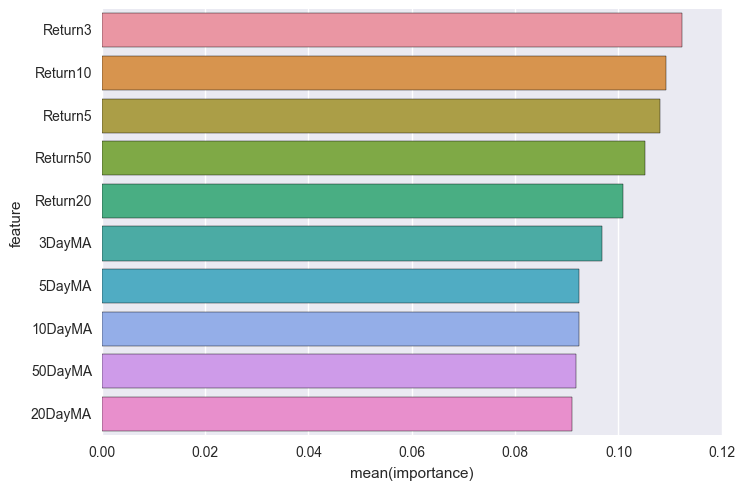

In [157]:
# Ensemble classifier
clf_imp = ExtraTreesClassifier(n_estimators=100, random_state = 0)
clf_imp = clf_imp.fit(X, y)

# Define features and importance
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf_imp.feature_importances_
features.sort(['importance'],ascending=False)

# Plot feature importance
sns.barplot(y = 'feature', x = 'importance', data=features.sort_values(by='importance', ascending=False))
plt.show()

In [141]:
# Code from Siraj
# Not working
def predict_prices(dates, prices, x):
	dates = np.reshape(dates,len(dates),1)

	svr_lin  = SVR(kernel = 'linear', C=1e3)
	svr_poly = SVR(kernel = 'poly',   C=1e3, degree = 2)
	svr_rbf  = SVR(kernel = 'rbf',    C=1e3, gamma  = 0.1)
	svr_lin.fit(dates,prices)
	svr_poly.fit(dates,prices)
	svr_rbf.fit(dates,prices)

	plt.scatter(dates, prices, color='black', label='Data')
	plt.plot(dates, svr_rbf.predict(dates), color='red', label='RBF Model')
	plt.plot(dates, svr_lin.predict(dates, color='green', label='Linear Model'))
	plt.plot(dates, svr_poly.predict(dates, color='blue', label='Polynomial Model'))
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.title('SVM')
	plt.legend()
	plt.show	

	return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]

# Support Vector Machine

In [30]:
from sklearn.svm import SVC

def performSVMClass(X_train, y_train, X_test, y_test):
    """
    SVM binary Classification
    """
    clf = SVC()
    clf.fit(X_train, y_train)
    
    accuracy = clf.score(X_test, y_test)
    
    return accuracy

In [31]:
accuracy = performSVMClass(X_train, y_train, X_test, y_test)
print(accuracy)

0.521172638436


In [ ]:
time_Start =time.time()

clf_SVC = SVC(kernel='poly')
#clf_SVC = clf_SVC.fit(X, y)
scores = cross_val_score(clf_SVC, X, y, cv=5)
print(scores)
print(scores.mean())

time_End = time.time()

print("Seconds to run:", time_End-time_Start )


# Polynomial SVM

In [6]:
""" This is stuck in training. Something wrong, have to see what
# Start timer
time_Start =time.time()

# Classifier
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)

# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

# End timer and results
time_End = time.time()
print("Seconds to run:", time_End-time_Start )
"""

' This is stuck in training. Something wrong, have to see what\n# Start timer\ntime_Start =time.time()\n\n# Classifier\nclf = SVC(kernel=\'poly\')\nclf.fit(X_train, y_train)\n\n# Prediction\nprediction = clf.predict(X_test)\nprint_evaluation(y_test, prediction)\n\n# End timer and results\ntime_End = time.time()\nprint("Seconds to run:", time_End-time_Start )\n'

# RBF SVM

In [ ]:
# Start timer
time_Start =time.time()

# Classifier
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

# End timer and results
time_End = time.time()
print("Seconds to run:", time_End-time_Start )

# Sigmoid SVM

In [ ]:
# Start timer
time_Start =time.time()

# Classifier
clf = SVC(kernel='sigmoid')
clf.fit(X_train, y_train)

# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

# End timer and results
time_End = time.time()
print("Seconds to run:", time_End-time_Start )